In [4]:
from utils import Data, get_ppi_edge_list
import pandas as pd
import numpy as np

In [5]:
ppi = get_ppi_edge_list()

(utils.py : 367) -    DEBUG | Loaded 24320 edges from the SIGNOR Network only


In [6]:
ppif = pd.DataFrame(ppi, columns=['geneA', 'geneB', 'weight'])
ppif

,geneA,geneB,weight
0,GOLGA7,HRAS,0.24
1,GOLGA7,ZDHHC9,0.55
2,ARHGAP22,CDC42,0.462
3,ARHGAP22,RHOA,0.481
4,ARHGAP22,RAC1,0.451
...,...,...,...
24315,EMSY,BRCA2,0.1
24316,EMSY,CBX1,0.1
24317,EMSY,ZMYND11,0.1
24318,GOLGA7,NRAS,0.319


In [7]:
data = Data(
    fGEP_SGA = 'data/CITRUS_GEP_SGAseparated.csv',
    fgene_tf_SGA = 'data/CITRUS_gene_tf_SGAseparated.csv',
    fcancerType_SGA = 'data/CITRUS_canType_SGAseparated.csv',
    fSGA_SGA = 'data/CITRUS_SGA_SGAseparated.csv',
)

In [9]:
pathway_names = dict(zip(np.load('pathway_names_keys.npy', allow_pickle=True), 
    np.load('pathway_names_values.npy', allow_pickle=True)))
pathway_names_inverse = dict(zip(np.load('pathway_names_values.npy', allow_pickle=True), 
                        np.load('pathway_names_keys.npy', allow_pickle=True)))
_pathways = np.load('_pathways.npy', allow_pickle=True)
reactome = np.load('./pnet_prostate_paper/train/reactome_layers.npy', allow_pickle=True)[::-1]

In [11]:
merged = {}
for k, v in reactome[1].items():
    gene_composition = []
    for i in v:
        for j in reactome[0].get(i, []):
            gene_composition.append(j)
    merged[k] = gene_composition

In [12]:
pathway_tf_mask = pd.DataFrame(np.zeros((320, 1066)), 
        index=data.gene_tf_sga.columns, 
        # columns=list(merged.keys())
        columns = _pathways[1]
    )

pathway_tf_mask = pathway_tf_mask.astype(int)

for gg in data.gene_tf_sga.columns:
    for k, v in merged.items():
        if gg in v:
            pathway_tf_mask.at[gg, pathway_names[k]] = 1
            
pathway_tf_mask = pathway_tf_mask.replace(0, np.nan).dropna(axis=1, how='all').fillna(0)
pathway_tf_mask = pathway_tf_mask.drop([None], axis=1)
# np.save('pathway_tf_mask.npy', pathway_tf_mask)
pathway_tf_mask.shape

(320, 169)

In [13]:
masks = np.load('./pnet_prostate_paper/train/maps.npy', allow_pickle=True)

In [14]:
merged2 = {}
for k, v in reactome[2].items():
    gene_composition = []
    for i in v:
        for j in reactome[1].get(i, []):
            gene_composition.append(j)    
    merged2[k] = gene_composition
len(merged2)

447

In [15]:
tf_ppi = {}
all_tfs = set(data.gene_tf_sga.columns)
for tf_gene in all_tfs:
    tf_ppi[tf_gene] = interacts_with(tf_gene).intersection(all_tfs)

In [16]:
pathway_tf_mask2 = pd.DataFrame(np.zeros((320, 447)), 
        index=data.gene_tf_sga.columns, 
        # columns=list(merged.keys())
        columns = _pathways[2]
    )

pathway_tf_mask2 = pathway_tf_mask2.astype(int)

merged2 = {}
for c in pathway_tf_mask2.columns:
    ref = pathway_names_inverse[c]
    gene_collection = []
    for ref2 in masks[2][ref][masks[2][ref] > 0].index: 
        for gi in  merged[ref2]:
            gene_collection.append(gi)

    merged2[c] = gene_collection
        
        
        
for gg in data.gene_tf_sga.columns:
    for k, v in merged2.items():
        if gg in v:
            pathway_tf_mask2.at[gg, k] = 1
            
# pathway_tf_mask2 = pathway_tf_mask2.replace(0, np.nan).dropna(axis=1, how='all').fillna(0)
# pathway_tf_mask2 = pathway_tf_mask2.drop([None], axis=1)
# # np.save('pathway_tf_mask.npy', pathway_tf_mask)
pathway_tf_mask2.shape, np.where(pathway_tf_mask2>0)[0].shape[0]

((320, 447), 448)

In [18]:
from tqdm.notebook import tqdm

In [25]:
interacts_with = lambda target_gene: set(
    ppif[
        ((ppif.geneA == 'AKT1') | (ppif.geneB == 'AKT1')) & 
        (ppif.weight > 0.8)][['geneA', 'geneB']].values.reshape(-1)
)

<AxesSubplot:xlabel='weight', ylabel='Density'>

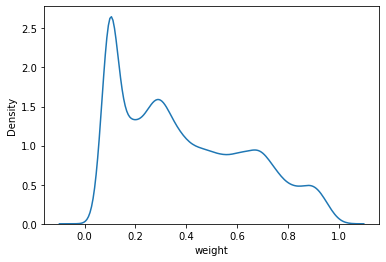

In [24]:
import seaborn as sns
sns.kdeplot(ppif.weight)

In [26]:
mm = np.array([
    [len(interacts_with(j).intersection(set(merged2[i]))) > 0 for i in pathway_tf_mask2.columns] 
        for j in tqdm(pathway_tf_mask2.index)])

  0%|          | 0/320 [00:00<?, ?it/s]

In [27]:
np.where(mm.astype(int) > 0)[0].__len__() / (np.multiply(*mm.shape))

0.09843400447427293

In [28]:
np.save('mm.npy', mm)

In [23]:
pathway_tf_mask2.values

,Phenylketonuria,Mitochondrial ABC transporters,mRNA decay by 3' to 5' exoribonuclease,Selenoamino acid metabolism,Synaptic adhesion-like molecules,Negative epigenetic regulation of rRNA expression,Plasma lipoprotein remodeling,Post-transcriptional silencing by small RNAs,"TET1,2,3 and TDG demethylate DNA",Phospholipid metabolism,...,Metallothioneins bind metals,Striated Muscle Contraction,DNA strand elongation,Nephrin family interactions,GPVI-mediated activation cascade,Ketone body metabolism,RHO GTPase Effectors,AMPK inhibits chREBP transcriptional activation activity,"Respiratory electron transport, ATP synthesis by chemiosmotic coupling, and heat production by uncoupling proteins.",Diseases associated with visual transduction
CDC5L,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PPARG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HOXB8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NFATC1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OVOL1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HMBOX1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FUBP1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZNF740,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CEBPZ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
